In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import MD_AE_tools.mode_decomposition as md

import configparser

# parameters
D       = 196.5;    # Model diameter in mm
Uinf    = 15;       # Nominal free stream velocity
fPIV    = 720;      # PIV sampling frequency
dt      = 1/fPIV;   # Delta t between image pairs
ly      = 300       # Domain size
lz      = 340

In [2]:
#=================== downsampled data ======================
filename = './data/PIV4_downsampled_by8.h5' # .h5 file of data
hf = h5py.File(filename,'r')
z = np.array(hf.get('z'))
y = np.array(hf.get('y'))
vy = np.array(hf.get('vy'))
vz = np.array(hf.get('vz'))
hf.close()
print("Finished loading data.")
# print(vy.shape)
ny = len(y)
nz = len(z)
[nt,nz,ny] = vz.shape

vy = np.transpose(vy,[2,1,0])
vz = np.transpose(vz,[2,1,0]) #(ny,nz,nt)
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
print(X.shape)


V = (vy**2 + vz**2)**0.5

Finished loading data.
(42, 24, 2732)


In [ ]:
#===================== read from training ======================
# # read from a result folder
# results_folder = 'MD_10__2022_05_21__17_29_44'
# config = configparser.ConfigParser()
# config.read('_system.ini')
# system_info = config['system_info']
# folder = system_info['save_location'] + '/' + results_folder + '/'
# filename = folder + 'results.h5'

# read from saved & partitioned data
filename = './data/training_data_unshuffle_1.h5'


hf = h5py.File(filename,'r')
# print(hf.keys())
u_in = np.array(hf.get('u_train'))[0,:,:,:,:]
u_train = np.array(hf.get('u_train'))
u_val = np.array(hf.get('u_val'))
u_avg = np.array(hf.get('u_mean_train'))# u_avg_test
hf.close()

[nt,ny,nz,nu] = u_in.shape

vy = u_in[:,:,:,0] + u_avg[:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = u_in[:,:,:,1] + u_avg[:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy))

V_test = (((u_in[:,:,:,0]+u_avg[:,:,0])**2)+((u_in[:,:,:,1]+u_avg[:,:,1])**2))**(0.5)
fig = plt.figure()
plt.imshow(V_test[0,:,:],'jet')
plt.colorbar()
plt.title('instantaneous velocity magnitude')
plt.show()

In [ ]:
#=================== vorticity ========================
dy = y[1]-y[0]
dz = z[1]-z[0]

vz_plus = np.roll(vz,-1,axis=0) # w_j+1,k matrix
vz_plus[-1,:,:] = 2*vz[-1,:,:] # set new matrix(ny,k) to w(ny,k)
vz_plus[0,:,:] = 2*vz_plus[0,:,:]
vz_minus = np.roll(vz,1,axis=0) # w_j-1,k matrix
vz_minus[0,:,:] = 2*vz[0,:,:] # set new matrix(0,k) to w(0,k)
vz_minus[-1,:,:] = 2*vz_minus[-1,:,:]

vy_plus = np.roll(vz,-1,axis=1) # v_j,k+1
vy_plus[:,-1,:] = 2*vy[:,-1,:]
vy_plus[:,0,:] = 2*vy_plus[:,0,:]
vy_minus = np.roll(vz,1,axis=1) # v_l,k-1
vy_minus[:,0,:] = 2*vy[:,0,:]
vy_minus[:,-1,:] = 2*vy_minus[:,-1,:]

dwdy = (vz_plus - vz_minus)/(2*dy) # central difference
dvdz = (vy_plus - vy_minus)/(2*dz)

# vorticity = dwdy-dvdz
vor = dwdy - dvdz
print(vor.shape)

plt.figure()
plt.imshow(vor[:,:,0]-np.mean(vor,axis=-1),'jet')
plt.colorbar()
plt.show()

### Make gif of vorticity

In [ ]:
from matplotlib import animation

fps = 10
sec = 10
skip = 2
vor_plt = vor[:,:,::skip]
# vor_plt = np.abs(vor_plt)
print(vor_plt.shape)

fig_gif = plt.figure()
im = plt.imshow(vor_plt[:,:,0],vmin=-0.6,vmax=0.6,cmap='jet')
plt.colorbar()
plt.title('Vorticity')
plt.xticks([])
plt.yticks([])
plt.show()

def animation_func(i):
    im.set_array(vor_plt[:,:,i])
    return[im]

gif = animation.FuncAnimation(fig_gif,
                                animation_func,
                                frames=np.arange(fps*sec),
                                interval=1000/fps,
                                repeat=False)

gif.save('u_in_vorticity.gif',fps=fps)

### POD

In [ ]:
# vorticity
pod = md.POD(vor,method='classic')
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean

fig = plt.figure()

for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[ny,nz])
    plt.imshow(np.abs(pltV),'jet',vmax=0.15)
    plt.colorbar()

energy = np.cumsum(lam/np.sum(lam))
plt.figure()
plt.plot(np.arange(len(energy))+1,energy)
plt.ylabel('energy')
plt.xlabel('mode')

In [3]:
pod_v = md.POD(X,method='classic')
Q_POD_v,lam_v = pod_v.get_modes()
Q_mean_v = pod_v.Q_mean

Calculating POD ...
User has selected classic POD
POD done.


/home/ym917/Documents/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:189: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


In [4]:
lam_v[:5]

array([220.69080706, 136.04505829,  93.6242865 ,  83.36394631,
        66.2812937 ])

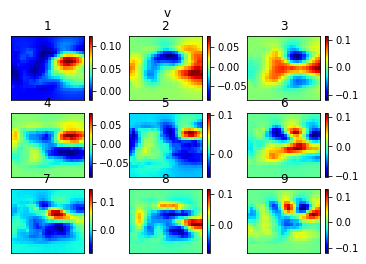

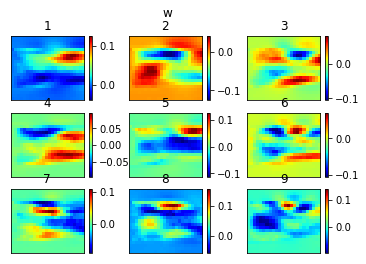

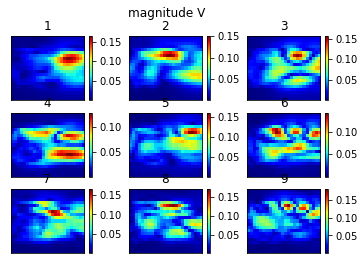

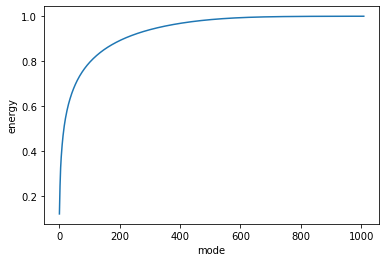

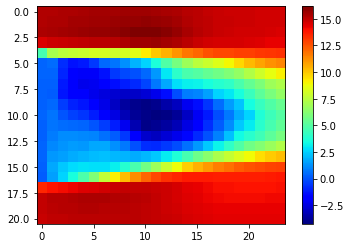

In [5]:
plt.figure()
plt.suptitle('v')
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD_v[:,iphi];
    pltV = np.reshape(pltV,[2*ny,nz])
    pltV = pltV[ny:,:]
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()

plt.figure()
plt.suptitle('w')
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD_v[:,iphi];
    pltV = np.reshape(pltV,[2*ny,nz])
    pltV = pltV[0:ny,:]
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()

plt.figure()
plt.suptitle('magnitude V')
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD_v[:,iphi];
    pltV = np.reshape(pltV,[2*ny,nz])
    pltV = (pltV[0:ny,:]**2 + pltV[ny:,:]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()

energy = np.cumsum(lam_v/np.sum(lam_v))
plt.figure()
plt.plot(np.arange(len(energy))+1,energy)
plt.ylabel('energy')
plt.xlabel('mode')

## Reconstruct
PlotWhichVelocity = 'w'
rebuildv = pod_v.reconstruct(number_of_modes=10,shape=[2,ny,nz,nt])
if PlotWhichVelocity == 'w': # Q was built [vz,vy]
    rebuildv = rebuildv[0,:,:,0]
elif PlotWhichVelocity == 'v':
    rebuildv = rebuildv[1,:,:,0]
elif PlotWhichVelocity =='V':
    rebuildv = (rebuildv[0,:,:,0]**2 + rebuildv[1,:,:,0]**2)**0.5
plt.figure()
plt.imshow(rebuildv,'jet')#-(np.sum(u_avg**2,axis=-1)**0.5)
plt.colorbar()
plt.show()

In [6]:
## calcualte mse of reconstructed flow

a = pod_v.reconstruct(number_of_modes=2,shape=[2,ny,nz,nt])
a = np.transpose(a,[3,1,2,0])
c = []
c.append(a[:,:,:,1])
c.append(a[:,:,:,0])
c = np.transpose(c,[1,2,3,0])
print(c.shape)
b = u_in+u_avg

# calculated mean squared error of POD reconstruction
def mse(x,y):
    return np.mean((x-y)**2)
print(mse(b,c))

# print(np.sum(lam_v[:10]))
# print(energy[9])

(2732, 21, 24, 2)


NameError: name 'u_in' is not defined

### Divergence

In [12]:
# calculated mean squared error of POD reconstruction
def mse(x,y):
    return np.mean((x-y)**2)
print(mse(b,c))

1.2411792716734507


In [ ]:
print(np.sum(lam_v[:10]))
print(energy[9])

## Ranking

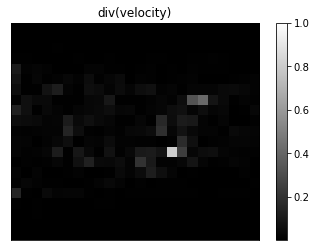

0.019900125041475022


In [15]:
## data
i = 30
dvdy = np.gradient(vy[:,:,i],y[1,0]-y[0,0],axis=0)
dwdz = np.gradient(vz[:,:,i],z[1,0]-z[0,0],axis=1)
plt.figure()
plt.title('div(velocity)')
plt.imshow(abs((dvdy+dwdz))/V[:,:,i],vmax=1,cmap='gray')
# plt.imshow(dvdy+dwdz)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()
print(np.mean(abs((dvdy+dwdz))/V[:,:,i]))

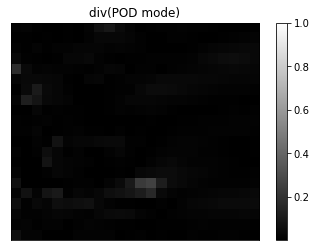

0.018370301037407732


In [22]:
## POD modes
i = 0
pltV = Q_POD_v[:,i];
pltV = np.reshape(pltV,[2*ny,nz])
modev = pltV[ny:,:]
pltV = Q_POD_v[:,i];
pltV = np.reshape(pltV,[2*ny,nz])
modew = pltV[0:ny,:]
pltV = Q_POD_v[:,i];
pltV = np.reshape(pltV,[2*ny,nz])
modeV = (pltV[0:ny,:]**2 + pltV[ny:,:]**2)**0.5
dmodevdy = np.gradient(modev,y[1,0]-y[0,0],axis=0)
dmodewdz = np.gradient(modew,z[1,0]-z[0,0],axis=1)
plt.figure()
plt.title('div(POD mode)')
plt.imshow(abs((dmodevdy+dmodewdz))/modeV,vmax=1,cmap='gray')
# plt.imshow(dmodevdy+dmodewdz)
# plt.imshow(modeV)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()
print(np.mean(abs((dmodevdy+dmodewdz))/modeV))

## Ranking

In [ ]:
# reshape the modes from pod
# how many modes to look at?
number_of_modes = 10
A = pod_v.A
pod_modes = []
for i in range(number_of_modes):
    m1 = A[:,[i]]@Q_POD_v[:,[i]].T
    m1 = np.reshape(m1,[len(A),2*ny,nz])
    m2 = np.stack((m1[:,ny:,:],m1[:,0:ny,:]),axis=3)
    pod_modes.append(m2)
pod_modes = np.array(pod_modes) # has shape(mode,time,y,z,u)

In [ ]:
# plot time coeficient A
A = pod_v.A
plt.figure()
plt.title('pod time coefficient')
for i in range(2):
    plt.plot(A[:,i],label=i+1)
plt.legend()
plt.xlim([0,600])

cov = A[:,:number_of_modes].T@A[:,:number_of_modes]/(A.shape[0]-1)
vmax = np.max(cov)
plt.figure()
plt.title('A.T@A')
plt.imshow(cov,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,number_of_modes+0.5,number_of_modes+0.5,0.5])
plt.xticks(np.arange(number_of_modes)+1)
plt.yticks(np.arange(number_of_modes)+1)
plt.colorbar()

plt.show()

sort_idx = np.argsort(np.diag(cov))
rank_var = np.arange(1,number_of_modes+1)[np.flip(sort_idx)]
print('rank:',rank_var)
det = np.linalg.det(np.corrcoef(A.T))
print('determinant of corr matrix: ',det) 

In [ ]:
## fft
signal_in = A[:,0]# which one
signal_fft = np.fft.fft(signal_in)
signal_fft_power = np.abs(signal_fft)/signal_in.size
signal_freq = np.fft.fftfreq(signal_in.size)
signal_freq = signal_freq/dt
# print(signal_freq.size/2)
plt.figure()
plt.bar(signal_freq[:int(signal_freq.size/2)],signal_fft_power[:int(signal_freq.size/2)])
plt.ylim(bottom=0)
plt.yticks([0])
plt.xlim(left=0)
loc,label = plt.xticks()
loc = np.r_[0:max(loc):25]
plt.xticks(loc)
plt.show()

In [ ]:
modes_E = np.copy(pod_modes)
rank_mse = np.zeros(number_of_modes,dtype='int')-1
for j in range(number_of_modes):
    E_ref = 0
    for i in range(number_of_modes):
        if i not in rank_mse:
            E = 1/mse(u_in,modes_E[i])
            if E > E_ref:
                E_ref = E
                rank_mse[j] = i
    modes_E = pod_modes + modes_E[rank_mse[j]]
rank_mse += 1

i_mse = []
for i in range(number_of_modes):
    i_mse.append(mse(u_in,pod_modes[i,:,:,:,:]))
sort_idx = np.argsort(i_mse)
rank_i_mse = np.arange(1,number_of_modes+1)[sort_idx]

ke = np.sum((pod_modes**2),axis=(4,3,2,1))
sort_idx = np.argsort(ke)
rank_ke = np.arange(1,number_of_modes+1)[np.flip(sort_idx)]

# print('rank_mse:            ',rank_mse)
# print('rank_i_mse:          ',rank_i_mse)
# print('rank_ke:             ',rank_ke)

In [ ]:
np.array_equal(rank_ke,np.arange(number_of_modes)+1)